# [WIP] OrderedProbit examples

Note: This is running PyMC v4. The latest (as of 20th Nov 2021) which includes [#5141](https://github.com/pymc-devs/pymc/pull/5141) merged.

This notebook is a work in progress and attempts to be a more up to date PyMC implementation of https://nbviewer.org/github/JWarmenhoven/DBDA-python/blob/master/Notebooks/Chapter%2023.ipynb

Once everything is working ok, then the goal is to provide a complete `pymc-examples` notebook on ordinal regression.

In [1]:
import pymc as pm
import pandas as pd
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import aesara.tensor as at
import seaborn as sns

pm.__version__

You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3


'4.0.0'

In [2]:
%config InlineBackend.figure_format = 'retina'

## Utility functions

In [3]:
def kplot(trace, n_cutpoints, ax=None):
    """Plot posterior cutpoints, ordered by mean of cutpoints"""
    cutpoints = trace.posterior['theta'].stack(sample=["chain", "draw"])
    sample_means = cutpoints.mean(dim="cutpoints").data
    sorted_indexes = np.argsort(sample_means)
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,5))
    for i in sorted_indexes:
        ax.plot(cutpoints.data[:,i], sample_means[i]*np.ones((n_cutpoints,1)), 'ko', alpha=0.01)
    ax.set(xlabel='threshold', ylabel='mean threshold')

In [4]:
def posterior_predictive(ppc, n_levels, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,5))

    # plot observed bin counts
    sns.countplot(x=y, color='C0', ax=ax);

    # plot errorbars
    y_obs = ppc.posterior_predictive['y_obs'].squeeze('chain').data
    ypp_stats = calc_y_stats(y_obs, n_levels)
    ax.plot(ypp_stats[1,:], 'ko')
    for i in np.arange(n_levels):
        ax.plot([i, i], [ypp_stats[0,i], ypp_stats[2,i]], 'k')
        
        
def calc_y_stats(y_obs, n_levels):
    """from a set of posterior predicted observations, return percentiles"""
    pp_samples = y_obs.shape[0]
    counts = np.zeros((pp_samples,n_levels))
    for i in range(pp_samples):
        counts[i,:] = np.bincount(y_obs[i,:], minlength=n_levels)
    return np.percentile(counts, [2.5, 50, 97.5], axis=0)

# Single group

## Load data

💣 Note: `y` observations must initvals at 0, not 1. 💣

In [5]:
df = pd.read_csv('data/OrdinalProbitData-1grp-1.csv')
y = df["Y"].values - 1
display(y)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 6])

K = 7 categories
K-1 = 6 thresholds


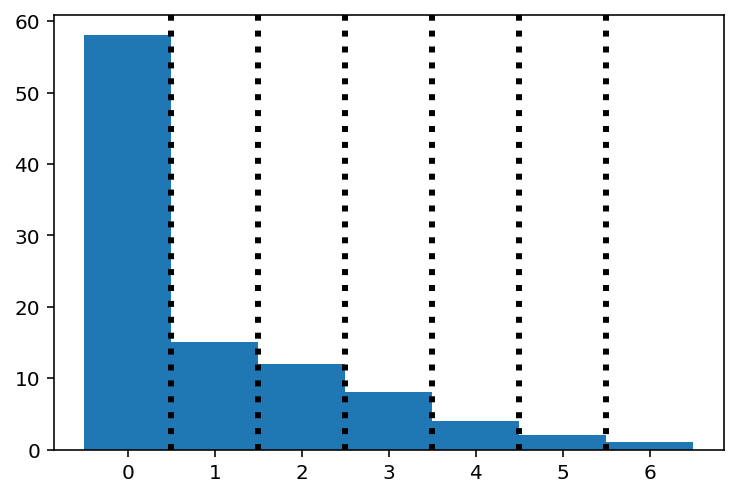

In [6]:
K = len(np.unique(y))
print(f"K = {K} categories")
print(f"K-1 = {K-1} thresholds")

plt.hist(y, bins=np.array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5])-1);
for i in np.arange(K-1)+0.5:
    plt.axvline(x=i, color='k', linestyle=":", lw=3)

## Naive, over-parameterized, model

In [7]:
initial = np.arange(K-1)+0.5
print(initial)

[0.5 1.5 2.5 3.5 4.5 5.5]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/benjamv/opt/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/aesara/tensor/elemwise.py:793: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/benjamv/git/pymc/pymc/model.py:925: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
/Users/benjamv/opt/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/aesara/tensor/elemwise.py:793: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, mu, sigma]
/Users/benjamv/git/pymc/pymc/model.py:925: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
/Users/benjamv/opt/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/aesara/tensor/elemwise.py:793: Runt

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


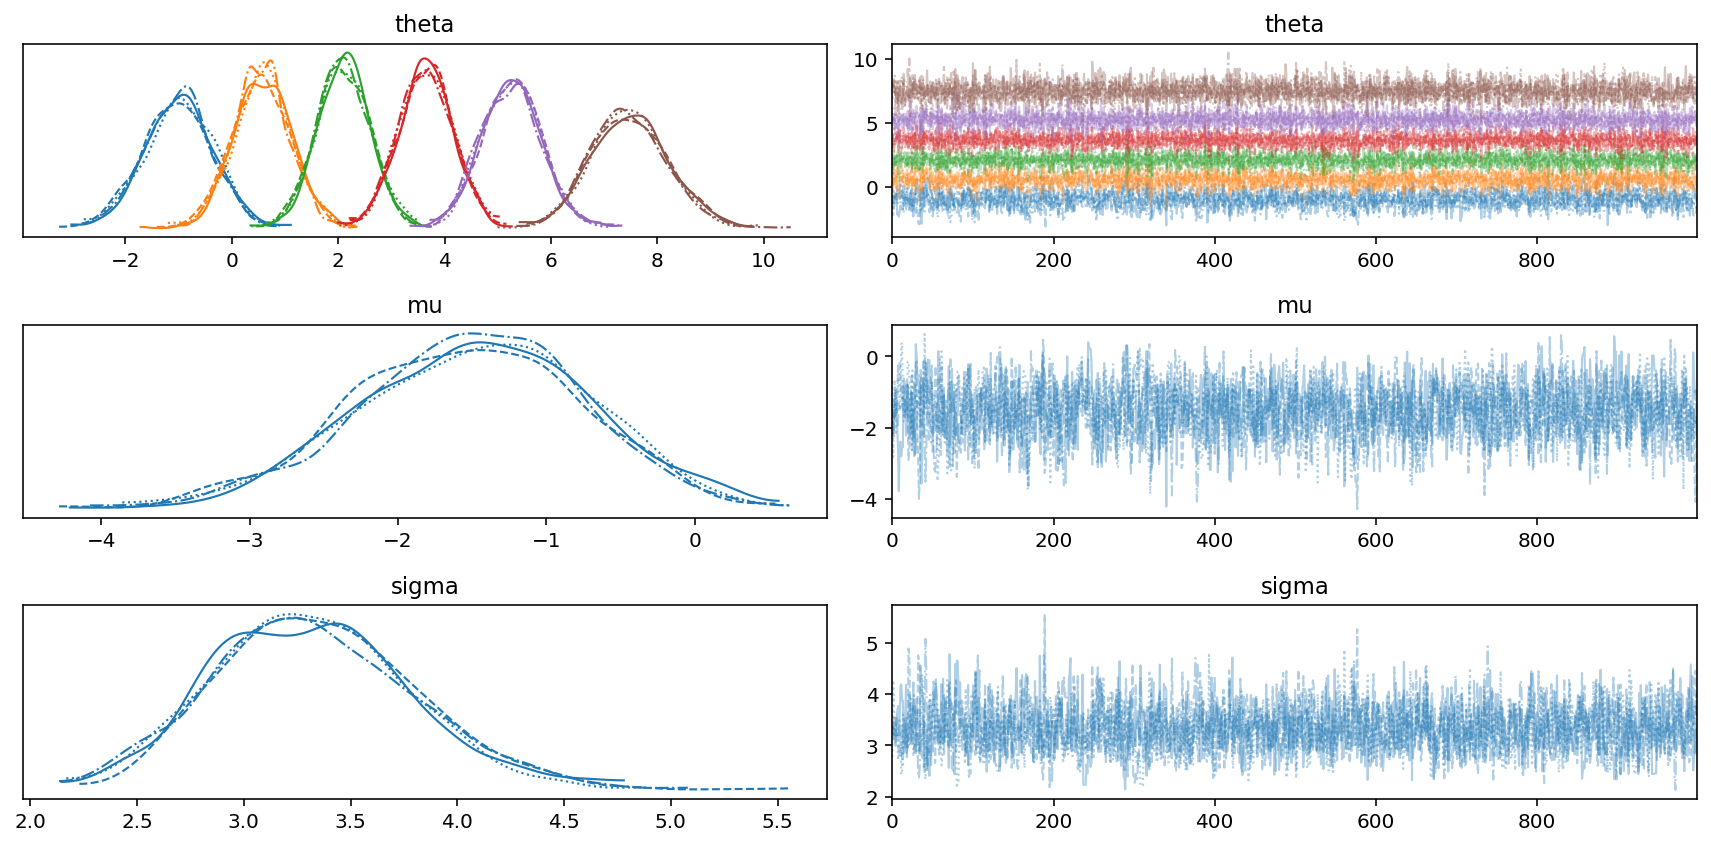

In [8]:
COORDS = {"obs": np.arange(len(y)), 
          "cutpoints": np.arange(K-1)}

with pm.Model(coords=COORDS) as model:
    cutpoints = pm.Normal("theta", 
                          mu=initial, 
                          sigma=1, 
                          dims='cutpoints',
                          transform=pm.distributions.transforms.ordered)
    mu = pm.Normal('mu', mu=K/2, sigma=K)
    sigma = pm.HalfNormal("sigma", 1)
    pm.OrderedProbit("y_obs", cutpoints=cutpoints, 
                     eta=mu, sigma=sigma, observed=y)
    
    trace = pm.sample(initvals={"theta": initial})
    ppc = pm.sample_posterior_predictive(trace)
    
# pm.model_to_graphviz(model)

az.plot_trace(trace, var_names=["theta", "mu", "sigma"]);
plt.tight_layout()

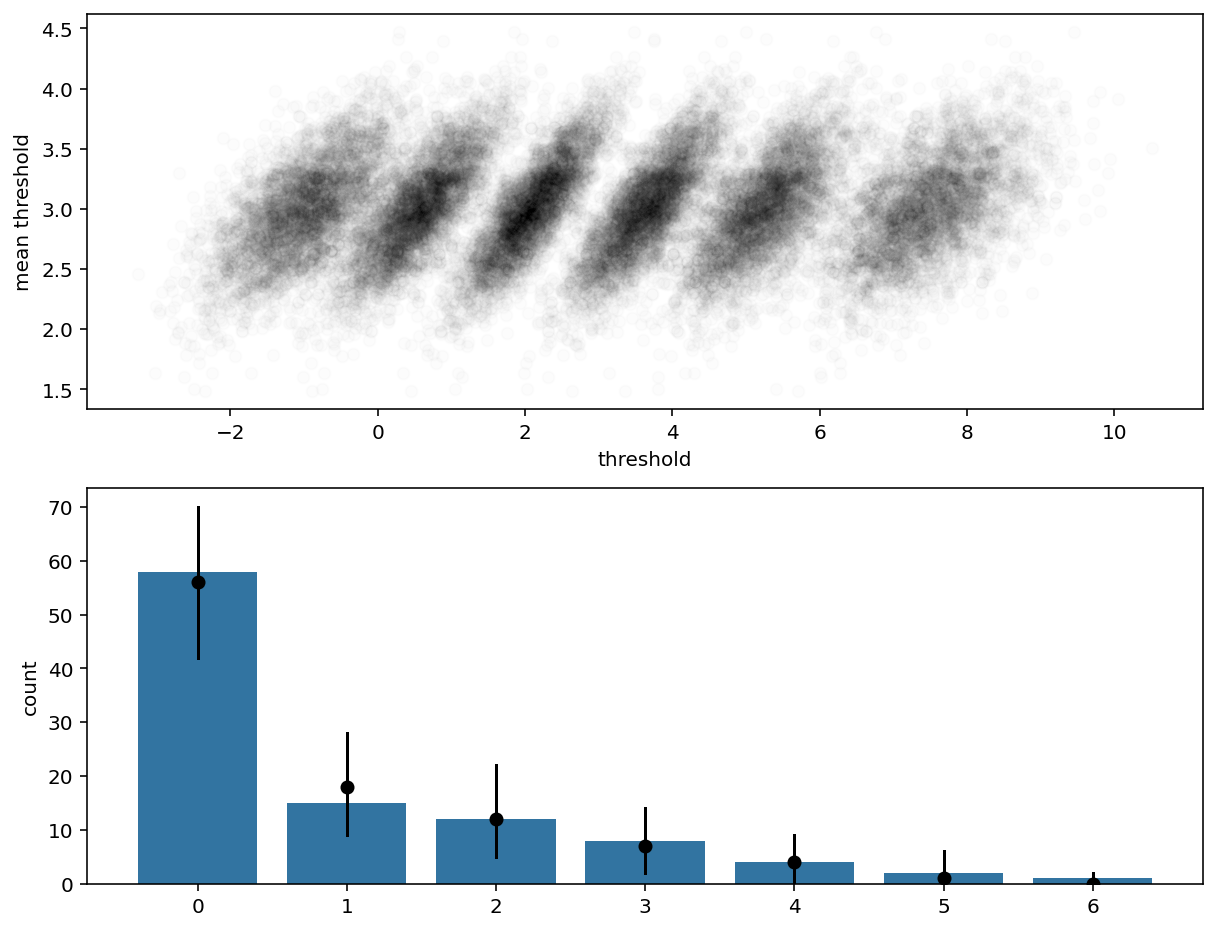

In [9]:
_, ax = plt.subplots(2, 1, figsize=(10, 8))
kplot(trace, K-1, ax[0])
posterior_predictive(ppc, K, ax[1])

This only looks vaguely sensible because the sd on the cutpoints is low. Fundamentally, the model is overparameterized, running inference with higher sd for the cutpoints shows this.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/benjamv/opt/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/aesara/tensor/elemwise.py:793: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/benjamv/git/pymc/pymc/model.py:925: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
/Users/benjamv/opt/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/aesara/tensor/elemwise.py:793: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, mu, sigma]
You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3
You are running the v4 d

/Users/benjamv/opt/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/aesara/compile/function/types.py:976: RuntimeWarning: invalid value encountered in add
  self.fn()
/Users/benjamv/opt/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/aesara/compile/function/types.py:976: RuntimeWarning: invalid value encountered in add
  self.fn()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


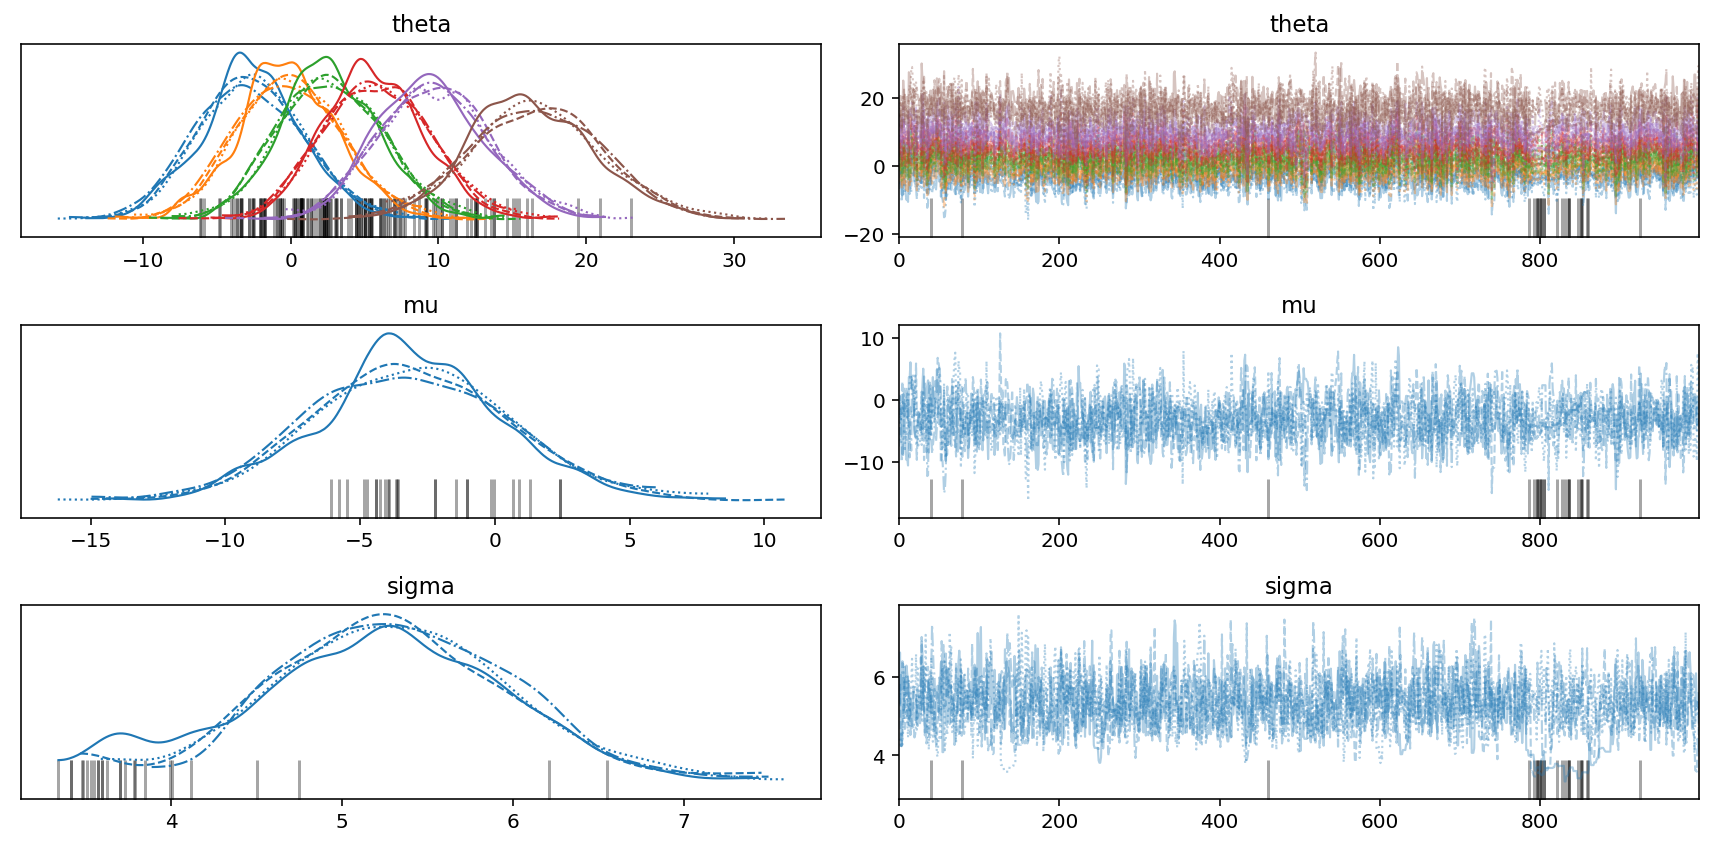

In [10]:
with pm.Model(coords=COORDS) as model:
    theta = pm.Normal("theta", 
                          mu=initial, 
                          sigma=10,  # <------------------------ HIGHER STD HERE
                          dims='cutpoints',
                          transform=pm.distributions.transforms.ordered)
    mu = pm.Normal('mu', mu=K/2, sigma=K)
    sigma = pm.HalfNormal("sigma", 1)
    pm.OrderedProbit("y_obs", cutpoints=theta, eta=mu, sigma=sigma, observed=y)
    
    trace = pm.sample(initvals={"theta": initial})
    ppc = pm.sample_posterior_predictive(trace)
    
# pm.model_to_graphviz(model)

az.plot_trace(trace, var_names=["theta", "mu", "sigma"]);
plt.tight_layout()

Now we have completely different estimates for the cutpoints, mu, and sigma.

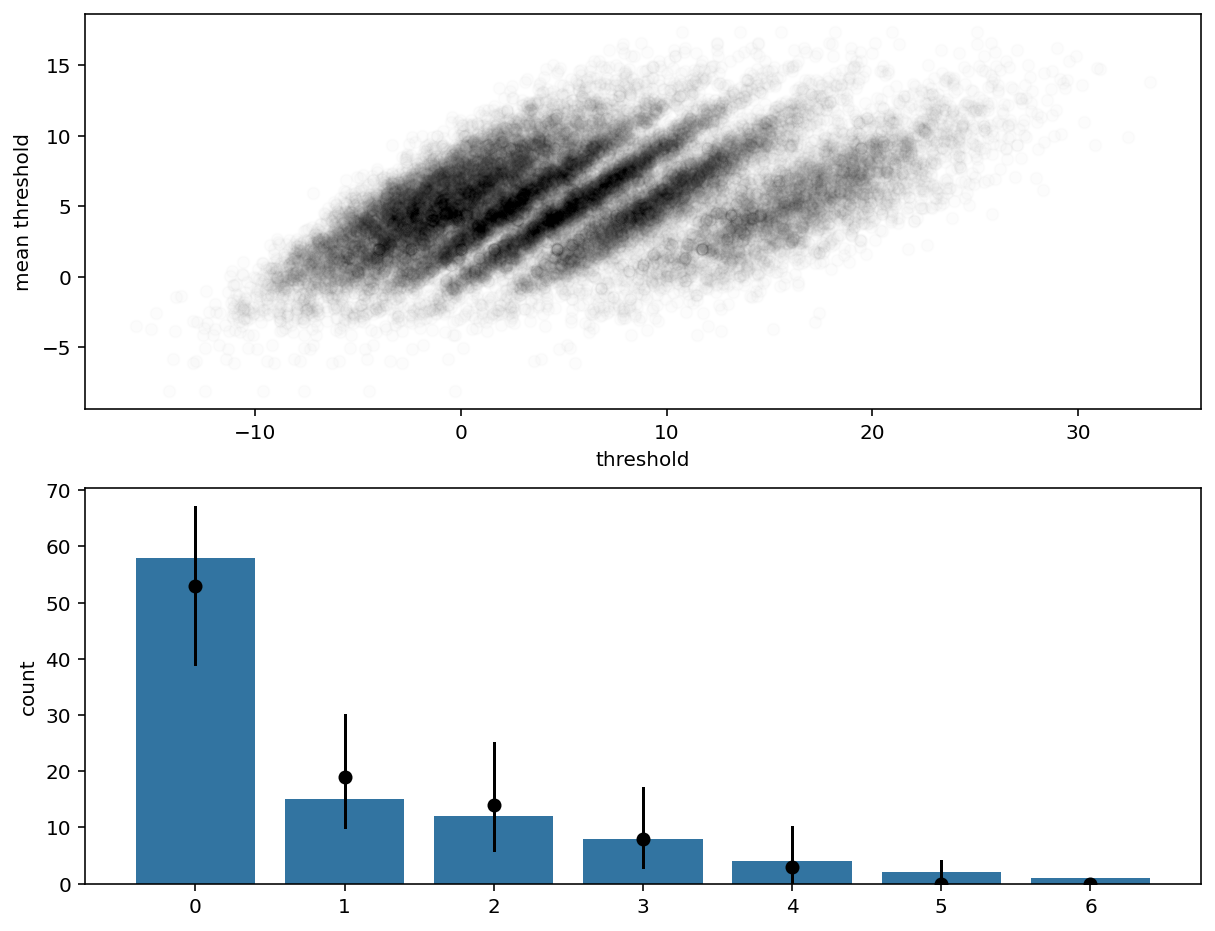

In [11]:
_, ax = plt.subplots(2, 1, figsize=(10, 8))
kplot(trace, K-1, ax[0])
posterior_predictive(ppc, K, ax[1])

## Let's avoid over-parameterization

There are $K$ ordinal levels of the data.

But the model has $K+1$ parameters: $\theta_1, \ldots, \theta_{K-1}, \mu, \sigma$.

So we have to reduce the degrees of freedom by 2.

We don't want to eliminate the mean by setting $\mu=0$ because having $\mu$ vary will be crucial when we have predictor variables.

### Lowest and highest cutpoints are constrained

Kruschke's approach is to pin down the lowest and the highest cutpoints such that:
- $\theta_1 = 1+0.5$
- $\theta_{K-1} = K-1+0.5$

For example, for a 7 point Likert scale, the first cutpoint would be 1.5 and the last would be 6.5.

In [12]:
# clip the first and last with [1:-1]
initial = (np.arange(K-1)+0.5)[1:-1]
print(initial)

COORDS = {"obs": np.arange(len(y)), 
          "cutpoints": np.arange(K-1)}

[1.5 2.5 3.5 4.5]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/benjamv/opt/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/aesara/tensor/elemwise.py:793: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/benjamv/git/pymc/pymc/model.py:925: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
/Users/benjamv/opt/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/aesara/tensor/elemwise.py:793: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_unknown, mu, sigma]
You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3
You are running 

/Users/benjamv/opt/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/aesara/compile/function/types.py:976: RuntimeWarning: invalid value encountered in add
  self.fn()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
There were 212 divergences after tuning. Increase `target_accept` or reparameterize.
There were 223 divergences after tuning. Increase `target_accept` or reparameterize.
There were 278 divergences after tuning. Increase `target_accept` or reparameterize.
There were 240 divergences after tuning. Increase `target_accept` or reparameterize.


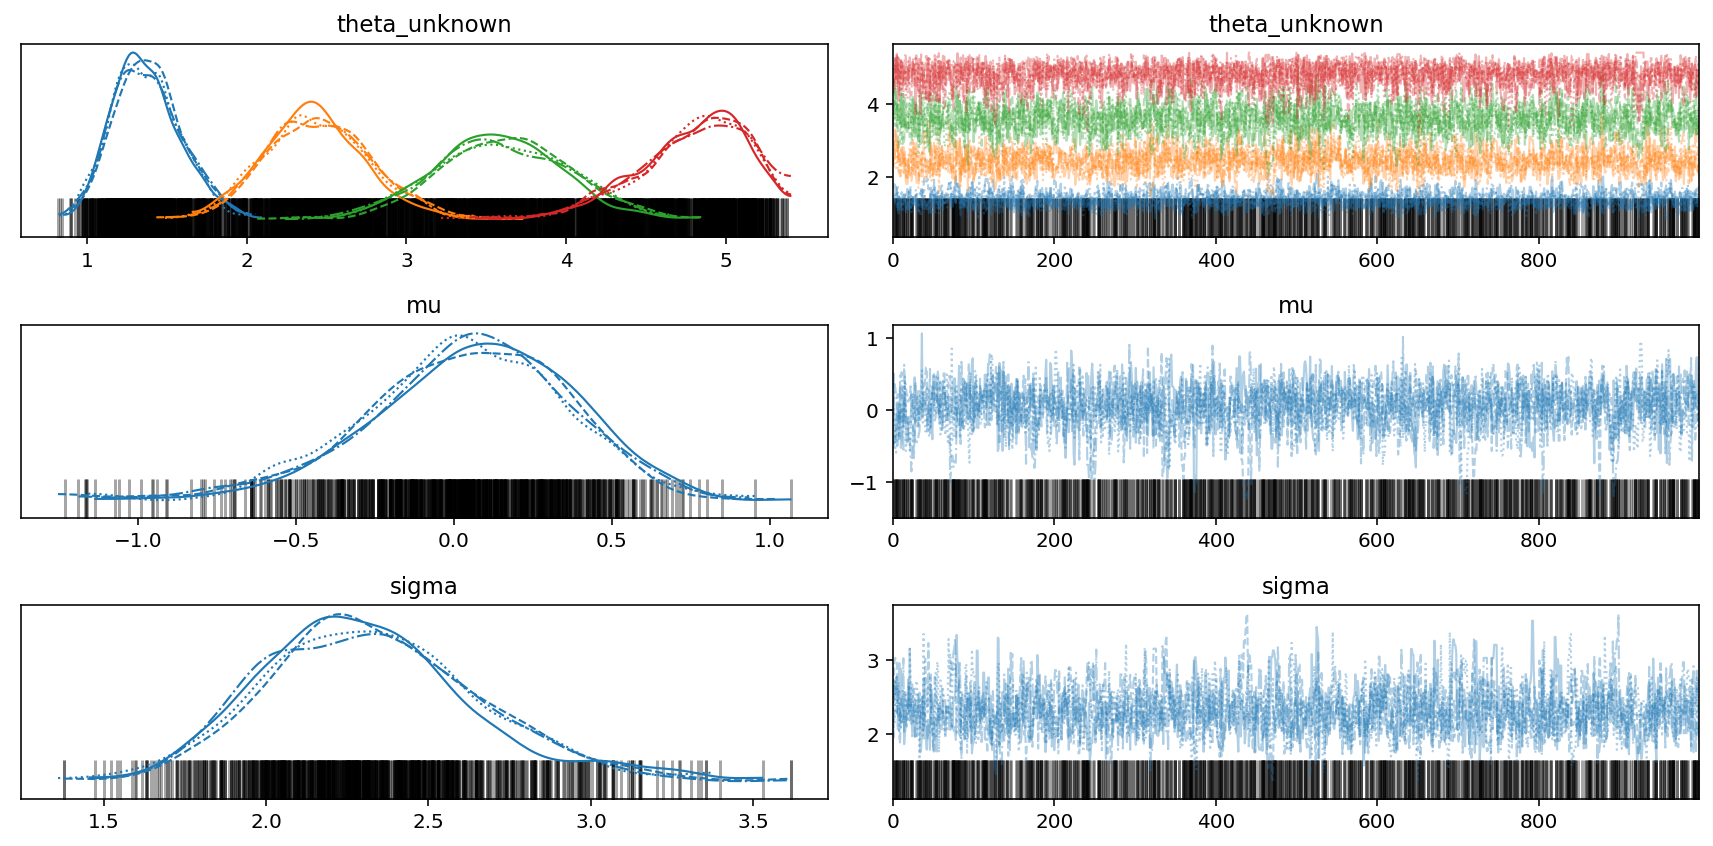

In [13]:
with pm.Model(coords=COORDS) as model:
    theta = pm.Deterministic("theta",
                             at.concatenate([
                                 np.ones(1) * 0.5,
                                 pm.Uniform("theta_unknown", 
                                            lower=1+0.5-1, 
                                            upper=K-0.5-1, 
                                            shape=K-1-2, transform=pm.distributions.transforms.ordered),
                                 np.ones(1) * (K - 1 - 0.5)
                             ]), dims='cutpoints')
    mu = pm.Normal('mu', mu=K/2, sigma=K)
    sigma = pm.HalfNormal("sigma", 1)
    pm.OrderedProbit("y_obs", cutpoints=theta, eta=mu, sigma=sigma, observed=y)
    
    trace = pm.sample(initvals={"theta_unknown": initial})
    ppc = pm.sample_posterior_predictive(trace)

# pm.model_to_graphviz(model)

az.plot_trace(trace, var_names=["theta_unknown", "mu", "sigma"]);
plt.tight_layout()

So this is 'fine' in that the posteriors are reasonable (compare the [DBA converted to PyMC post](https://nbviewer.org/github/JWarmenhoven/DBDA-python/blob/master/Notebooks/Chapter%2023.ipynb)). But we've got an intense divergence problem.

Note that the divergences do _not_ resolve if we use `pm.distributions.transforms.ordered` on the uniform distribution of unknown cutpoints.

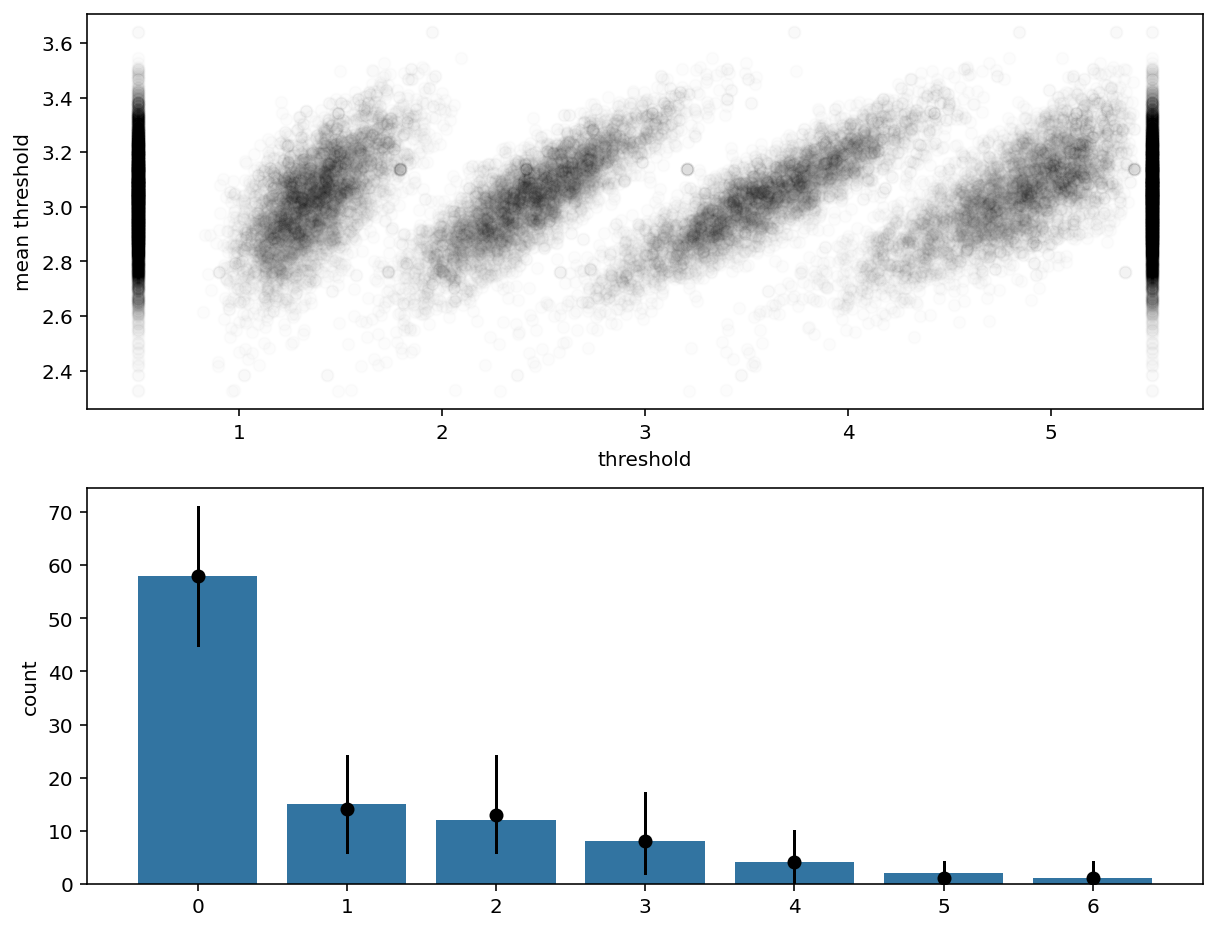

In [14]:
_, ax = plt.subplots(2, 1, figsize=(10, 8))
kplot(trace, K-1, ax[0])
posterior_predictive(ppc, K, ax[1])

### Fix lowest cutpoint to zero and constrain sum of cutpoints to be 1 with a Dirichlet distribution
Another approach, suggested by Adrian, is to fix the lower cutpoint to zero and use a Dirichlet distribution for the remaining unknown cutpoints. This has one less degree of freedom (I believe) because the sum of the Dirichlet distributed cutpoints will be 1.

In [15]:
# clip the first and last with [1:]
initial = (np.arange(K-1.5))[1:]
print(initial)

COORDS = {"obs": np.arange(len(y)), 
          "cutpoints": np.arange(K-1)}

[1. 2. 3. 4. 5.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/benjamv/git/pymc/pymc/model.py:925: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_unknown, mu, sigma]
You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3
You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3
You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via c

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
There were 254 divergences after tuning. Increase `target_accept` or reparameterize.
There were 194 divergences after tuning. Increase `target_accept` or reparameterize.
There were 277 divergences after tuning. Increase `target_accept` or reparameterize.
There were 226 divergences after tuning. Increase `target_accept` or reparameterize.


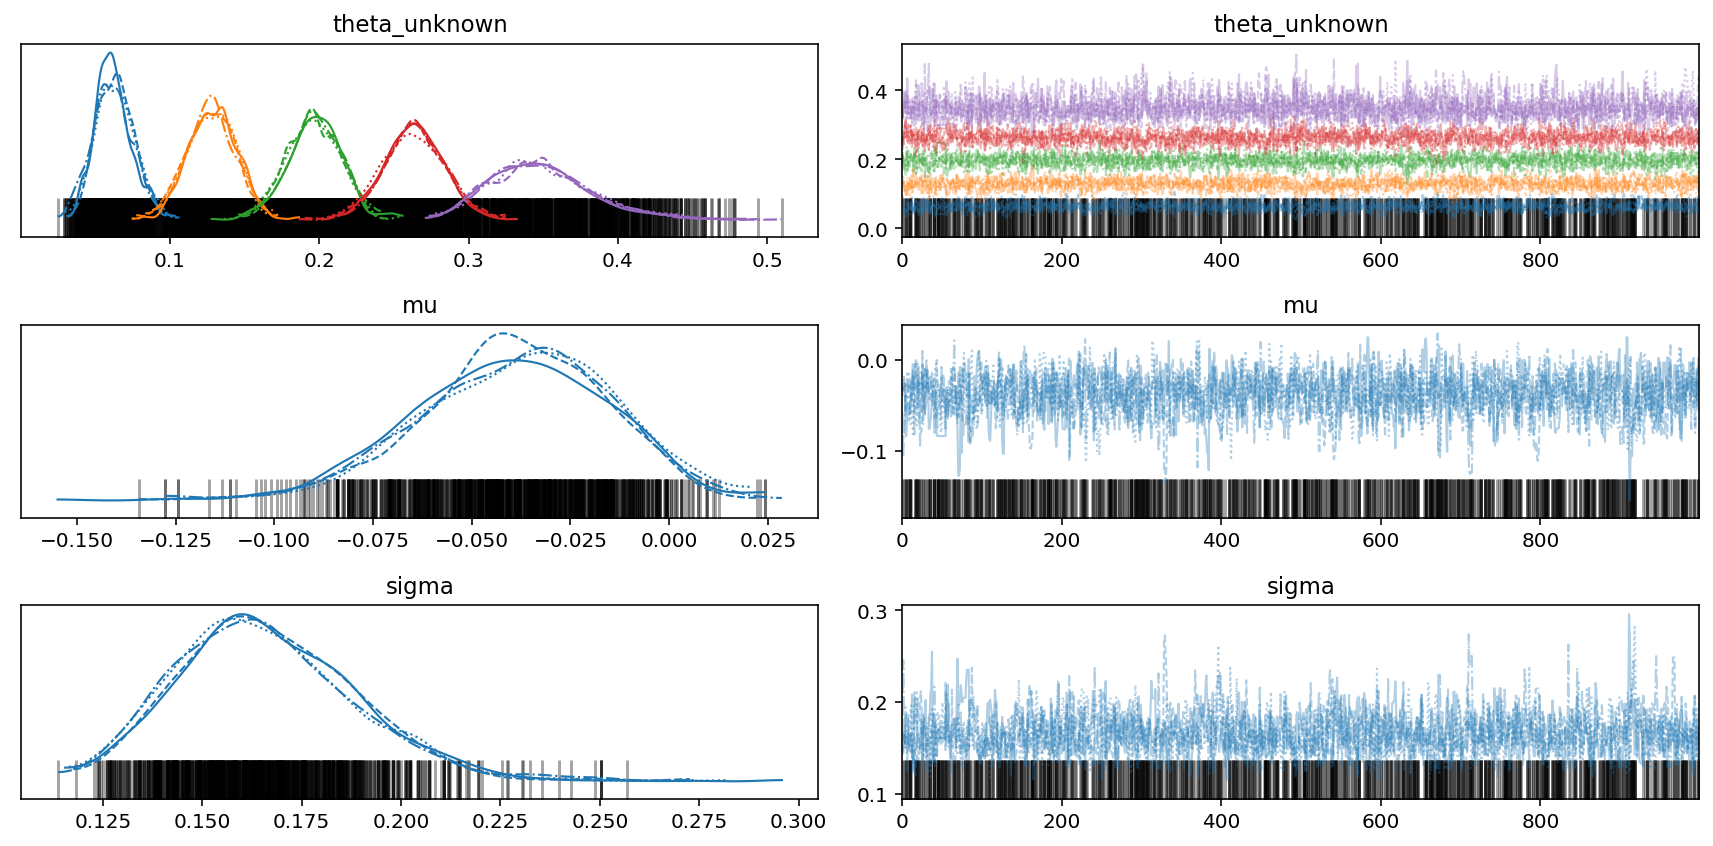

In [16]:
with pm.Model(coords=COORDS) as model:
    theta = pm.Deterministic('theta',
                                 at.concatenate([
                                     np.zeros(1),
                                     pm.Dirichlet("theta_unknown", a=np.ones(K - 1 - 1))
                                 ]), dims='cutpoints')
    mu = pm.Normal('mu', mu=K/2, sigma=K)
    sigma = pm.HalfNormal("sigma", 1)
    pm.OrderedProbit("y_obs", cutpoints=theta, eta=mu, sigma=sigma, observed=y)
    
    trace = pm.sample(initvals={"theta_unknown": initial})
    ppc = pm.sample_posterior_predictive(trace)
    
# pm.model_to_graphviz(model)

az.plot_trace(trace, var_names=["theta_unknown", "mu", "sigma"]);
plt.tight_layout()

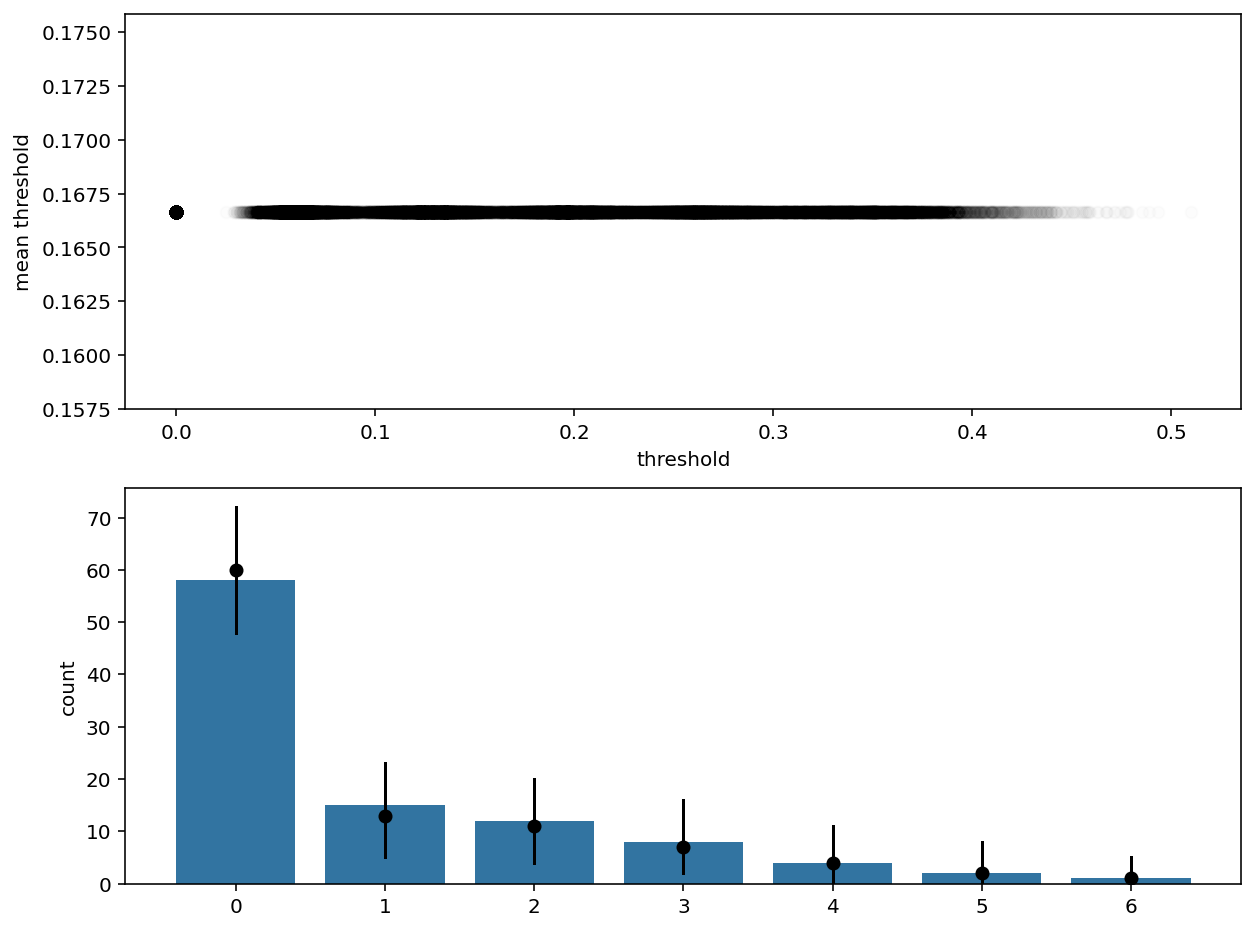

In [17]:
_, ax = plt.subplots(2, 1, figsize=(10, 8))
kplot(trace, K-1, ax[0])
posterior_predictive(ppc, K, ax[1])

What about ordering the Dirichlet variables?

We can use `aesara.tensor.extra_ops.cumsum` to see if ordering the Dirichlet variables helps.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.1 0.3 0.5 0.7 0.9]


/Users/benjamv/git/pymc/pymc/model.py:925: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_unknown, mu, sigma]
You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3
You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3
You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


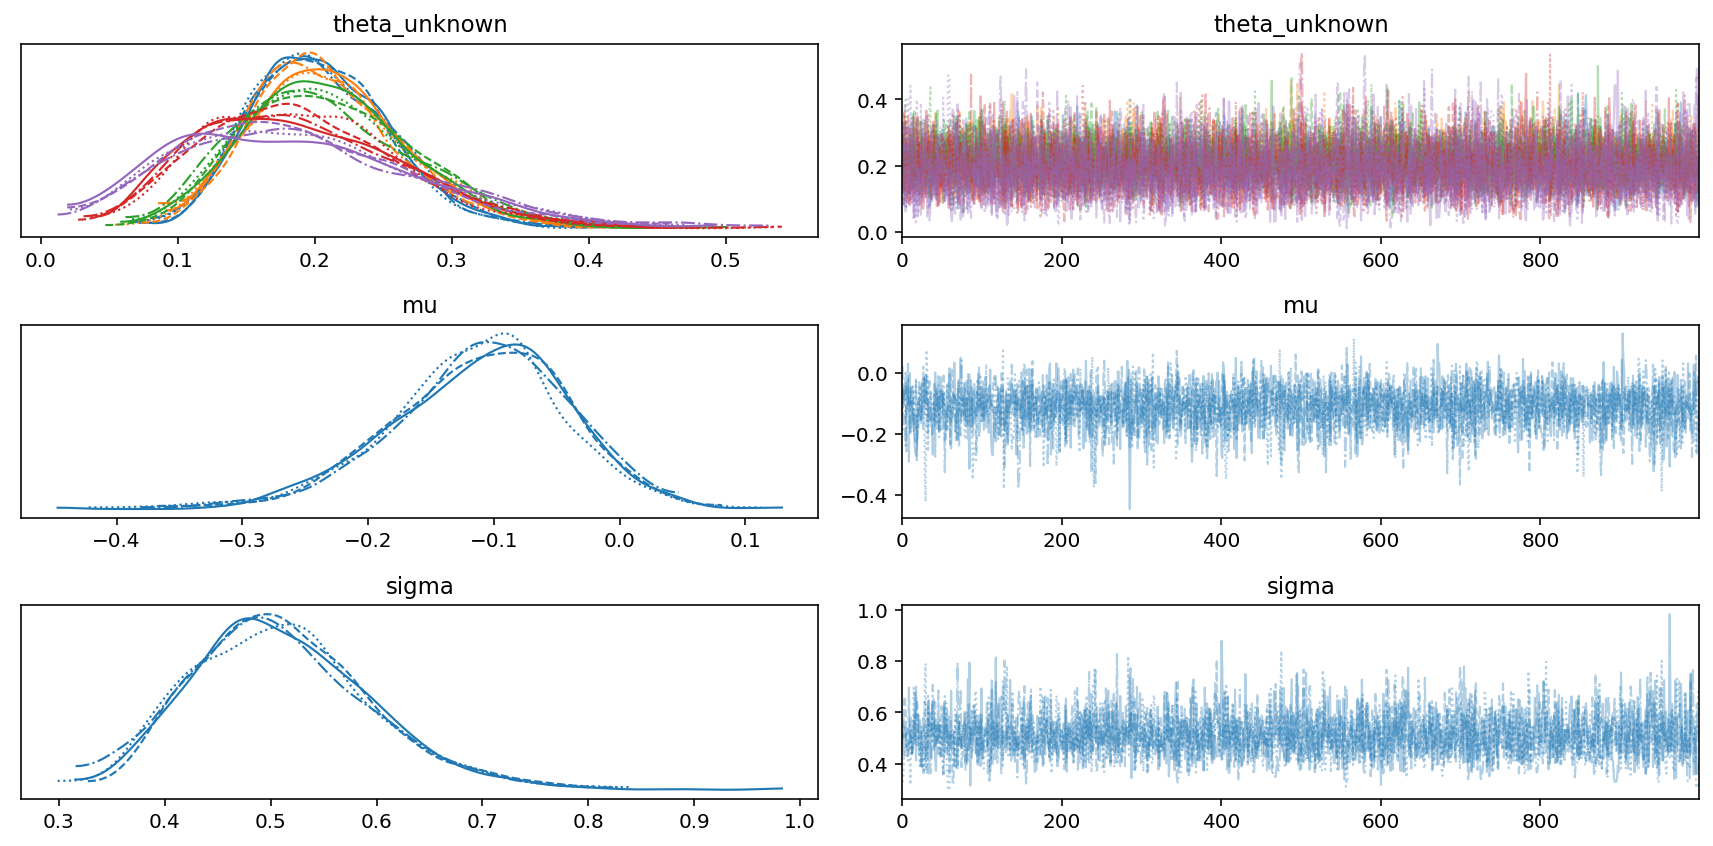

In [18]:
initial = np.linspace(0.1, 0.9, K-2)
print(initial)

with pm.Model(coords=COORDS) as model:
    theta = pm.Deterministic('theta',
                             at.concatenate([
                                 np.zeros(1),
                                 at.extra_ops.cumsum(pm.Dirichlet("theta_unknown", a=np.ones(K - 1 - 1)))
                             ]), dims='cutpoints')
    mu = pm.Normal('mu', mu=K/2, sigma=K)
    sigma = pm.HalfNormal("sigma", 1)
    pm.OrderedProbit("y_obs", cutpoints=theta, eta=mu, sigma=sigma, observed=y)
    
    trace = pm.sample(initvals={"theta_unknown": initial})
    ppc = pm.sample_posterior_predictive(trace)

az.plot_trace(trace, var_names=["theta_unknown", "mu", "sigma"]);
plt.tight_layout()

Well, divergences are gone!

The posterior distributions of cutpoints look strange in that they strongly overlap.

But this puzzle is resolved when we use the Kruschke style of plotting cutpoints as a function of mean cutpoint (below).

So the lesson seems to be that we _do_ need the cutpoints to be ordered in order to avoid the divergences.

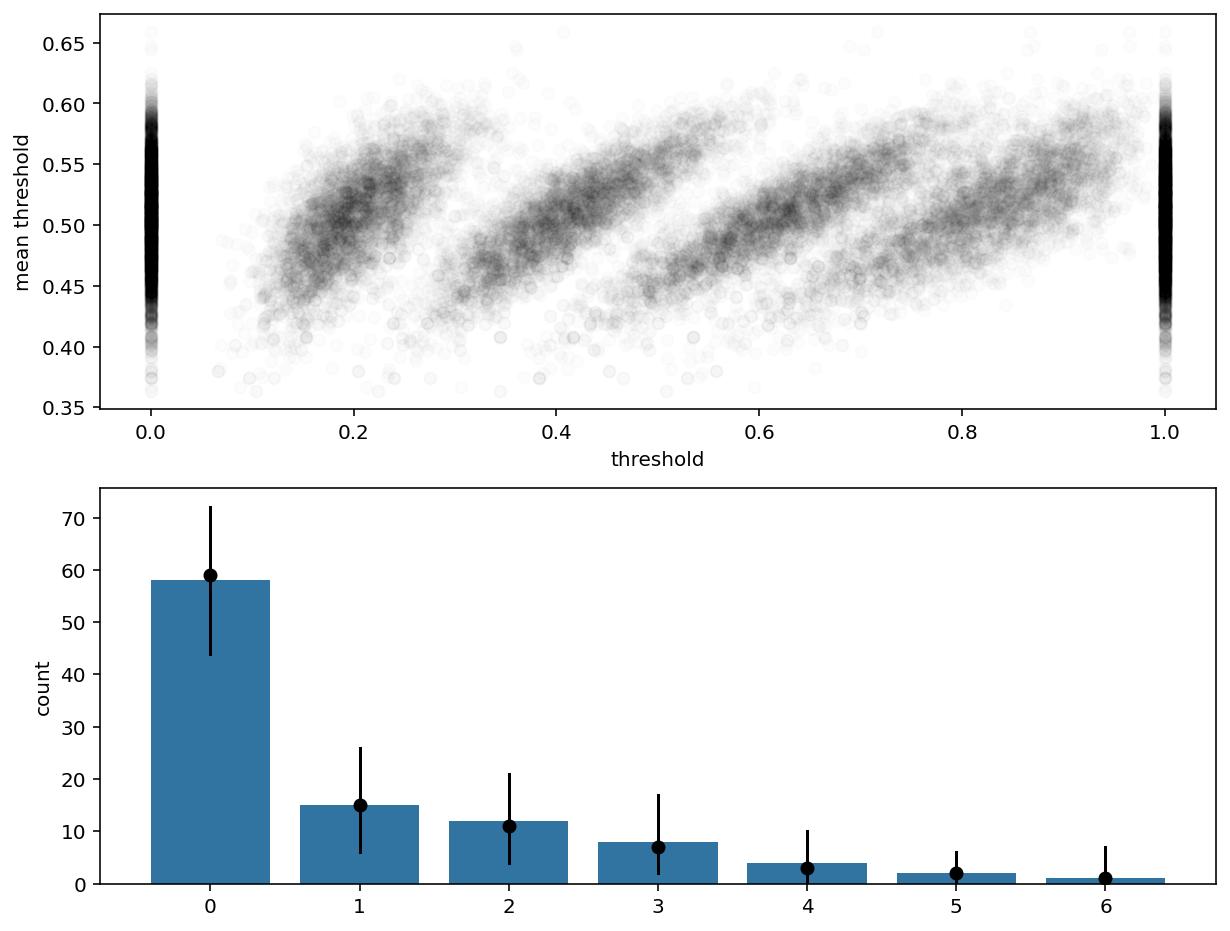

In [19]:
_, ax = plt.subplots(2, 1, figsize=(10, 8))
kplot(trace, K-1, ax[0])
posterior_predictive(ppc, K, ax[1])

# The Case of Two Groups

# The Case of Metric Predictors